# 4. Transaction Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

transaction = pd.read_parquet("../data/curated/transaction/transaction_merged.parquet")

## 4.1 Remove odd values in transaction

1. Remove odd/small value in transaction

In [2]:
count_below_005 = (transaction['dollar_value'] < 0.05).sum()
print('There are',count_below_005, 'below 0.05')
transaction = transaction[transaction['dollar_value'] >= 0.05].reset_index(drop=True)

There are 5101 below 0.05


2. Remove merchant with small amount of transaction 

In [3]:
transaction_count = transaction.groupby('merchant_abn')['dollar_value'].sum().reset_index()

# Calculate the 5th percentile value
percentile_5 = np.percentile(transaction_count['dollar_value'], 5)

# Filter groups where 'sum' is greater than or equal to the 5th percentile
filtered_groups = transaction_count[transaction_count['dollar_value'] >= percentile_5]

# Create a mask to filter rows in the original 'transaction' DataFrame
mask = transaction['merchant_abn'].isin(filtered_groups['merchant_abn'])

# Apply the mask to remove rows from the 'transaction' DataFrame
transaction = transaction[mask]


3. Remove merchant with less transaction record

In [4]:
# Group by 'merchant_abn' and count the transactions
merchant_counts = transaction.groupby('merchant_abn').size().reset_index(name='transaction_count')
threshold = merchant_counts['transaction_count'].quantile(0.05)
merchants_to_remove = merchant_counts[merchant_counts['transaction_count'] < threshold]['merchant_abn']
transaction = transaction[~transaction['merchant_abn'].isin(merchants_to_remove)]
transaction.reset_index(drop=True, inplace=True)

4. check mean and std of each merchant

In [5]:
abn = transaction.groupby('merchant_abn')['dollar_value'].agg(['std', 'mean']).reset_index()
abn.columns = ['merchant_abn', 'std_by_abn', 'mean_by_abn']
top_10_max_std = abn.nlargest(10, 'std_by_abn')
top_10_max_std

,merchant_abn,std_by_abn,mean_by_abn
1960,53918538787,19813.433769,23923.157429
3651,91880575299,18322.961715,20250.295557
3285,83199298021,13027.822507,19626.613727
3859,96730987906,12973.363065,20840.300160
47,11149063370,12599.686053,17975.544995
3276,82999039227,12511.646867,16111.161901
395,19010030815,11856.762635,17054.869877
1999,54860127682,11721.943459,21194.081414
3358,85117752663,11298.631098,10519.138354
1383,41001282470,11265.938776,16230.682003


In [6]:
zero_std_abn = abn[abn['std_by_abn'] == 0]['merchant_abn']
zero_std_transactions = transaction[transaction['merchant_abn'].isin(zero_std_abn)]
zero_std_transactions

,user_id,merchant_abn,dollar_value,order_id,order_datetime
169,18611,43349891433,157.0,40e4862f-c401-4bb0-b693-0820e2509cdf,2021-02-28
659,441,24015173965,157.0,911ddc6e-800c-4792-b6de-bb407120ba27,2021-02-28
924,643,65204103269,157.0,90446bbe-d2b2-4f68-b4b0-7eb4fcca7e70,2021-02-28
1288,19422,66571984047,157.0,0778d6db-237c-4240-a35f-6959144deb14,2021-02-28
1577,1107,24015173965,157.0,d719713b-411a-4b47-b5b0-f9a3a97dbdec,2021-02-28
...,...,...,...,...,...
14166334,22021,43660707274,157.0,36915a06-38d0-4d05-b11a-25383973634c,2022-10-26
14167218,9607,66571984047,157.0,ccaff474-d62d-43bc-92f8-35de9a568957,2022-10-26
14168208,10484,24015173965,157.0,f471f23a-7d2d-4426-af22-4c1e5ce9fbb7,2022-10-26
14168228,10502,66571984047,157.0,5c224970-4a80-42d4-bb7e-4fafdede2040,2022-10-26


In [10]:
# save cleaned transaction in to new parquet form
transaction.to_parquet('../data/curated/transaction/transaction_cleaned.parquet')
consumer = pd.read_csv('../data/curated/consumer/consumer_merge.csv')
transcation_consumer = pd.merge(transaction, consumer, on='user_id', how='left')
transcation_consumer.to_parquet('../data/curated/transaction/transaction_consumer_cleaned.parquet')

## 4.2 Visualization of distribution of transaction by day

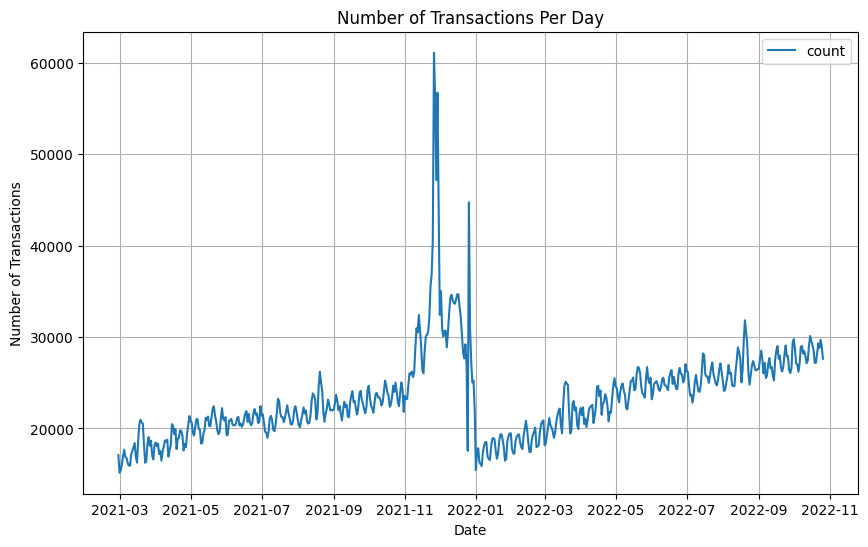

In [9]:
#line plot of number of transaction each day 
transaction['order_datetime'] = pd.to_datetime(transaction['order_datetime'])
# Group transactions by 'order_datetime' and count the number of transactions for each day
transaction_by_date = transaction.groupby(transaction['order_datetime'].dt.date).size().reset_index(name='count')
# Create a line plot
transaction_by_date.plot(kind='line', x='order_datetime', y='count', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions Per Day')
plt.grid(True)
plt.savefig('../plots/transaction_by_date.png')
plt.show()